<a href="https://colab.research.google.com/github/DavoodSZ1993/Dive_into_Deep_Learning/blob/main/14_1_image_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==1.0.0-alpha1.post0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.1 MB/s eta 0:00:00


## 14.1 Image Augmentation

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

### 14.1.1 Common Image Augmentation Methods

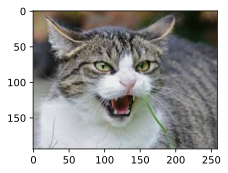

In [10]:
d2l.set_figsize()
img = d2l.Image.open('cat.jpg')
d2l.plt.imshow(img);

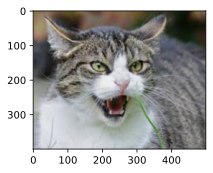

In [11]:
import torchvision.transforms as T

transform = T.Resize((400, 500))
img = transform(img)
d2l.plt.imshow(img);

In [12]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
  Y = [aug(img) for _ in range(num_rows * num_cols)]
  d2l.show_images(Y, num_rows, num_cols, scale=scale)

#### Flipping and Cropping

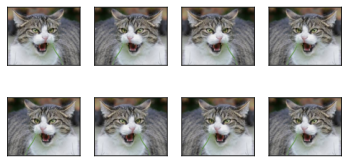

In [13]:
apply(img, T.RandomHorizontalFlip())

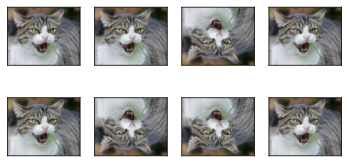

In [14]:
apply(img, T.RandomVerticalFlip())

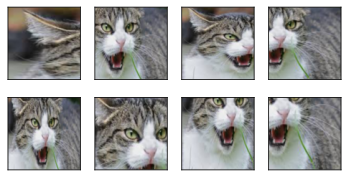

In [21]:
shape_aug = T.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))

apply(img, shape_aug)

#### Changing Colors

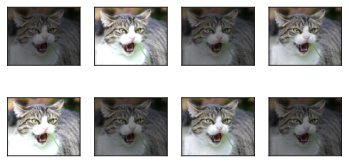

In [15]:
apply(img, T.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

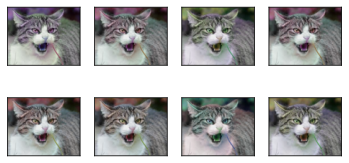

In [16]:
apply(img, T.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

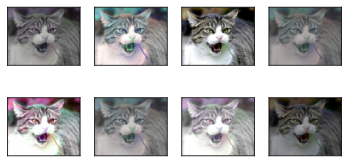

In [17]:
color_aug = T.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

#### Combining Multiple Image AUgmentation Methods

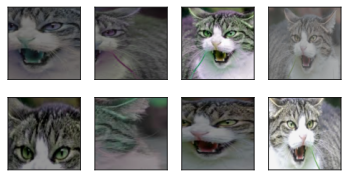

In [22]:
augs = T.Compose([
    T.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

### 14.1.2 Training with Image Augmentation

Files already downloaded and verified


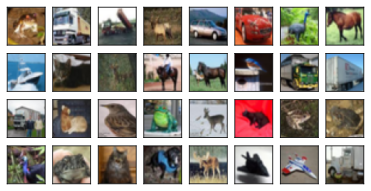

In [23]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [24]:
train_augs = T.Compose([T.RandomHorizontalFlip(), T.ToTensor()])
test_augs = T.Compose([T.ToTensor()])

In [25]:
def load_cifar10(is_train, augs, batch_size):
  dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                         transform=augs, download=True)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           shuffle=is_train, num_workers=d2l.get_dataloader_workers())
  return dataloader

#### Multi-GPU Training (Not Available Here!)

In [26]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
  if isinstance(X, list):
    X = [x.to(devices[0]) for x in X] # Required for BERT fine-tuning
  else:
    X = X.to(devices[0])
  y = y.to(devices[0])
  net.train()
  trainer.zero_grad()
  pred = net(X)
  l = loss(pred, y)
  l.sum().backward()
  trainer.step()
  train_loss_sum = l.sum()
  train_acc_sum = d2l.accuracy(pred, y)
  return train_loss_sum, train_acc_sum

In [27]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, 
               devices = d2l.try_all_gpus()):
  timer, num_batches = d2l.Timer(), len(train_iter)
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                          legend=['train loss', 'train_acc', 'test_acc'])
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l, acc = train_batch_ch13(
          net, features, labels, loss, trainer, devices)
      metric.add(l, acc, labels.shape[0], labels.numel())
      timer.stop()
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, 
                     (metric[0] / metric[2], metric[1] / metric[3], None))
    test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
  print(f'loss {metric[0] / metric[2]: .3f}, train_acc '
        f'{metric[1] / metric[3]:.3f}, test acc {test_acc: .3f}')
  print(f'{metric[2] * num_epochs / timer.sum(): .1f} examples/sec on '
        f'{str(devices)}')

In [28]:
batch_size, devices, net = 256, d2l.d2l.try_all_gpus(), d2l.resnet18(10, 3);
net.apply(d2l.init_cnn);

In [29]:
def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
  train_iter = load_cifar10(True, train_augs, batch_size)
  test_iter = load_cifar10(False, test_augs, batch_size)
  loss = nn.CrossEntropyLoss(reduction="none")
  trainer = torch.optim.Adam(net.parameters(), lr=lr)
  net(next(iter(train_iter))[0])
  train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss  0.203, train_acc 0.931, test acc  0.831
 1168.4 examples/sec on [device(type='cuda', index=0)]


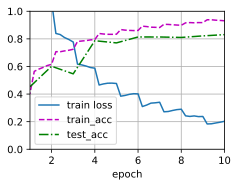

In [30]:
train_with_data_aug(train_augs, test_augs, net)